# CNN Classification in a Nutshell

This example demontrates how global average pooling (GAP) can replace a dense layer in CNN based classification while enabling generation and visualization of class activation maps simultaneously. The input image, size 6x6, is divided into 4 quadrants as follows: 

$$
\begin{bmatrix}
0 & 1 \\
2 & 3
\end{bmatrix}
$$

Each of the quadrants can have one of the following objects:

* empty, class 0
* horizontal line, class 1
* vertical line, class 2

Following example contains a horizontal line in the 0th quadrant and a vertical line in the 3rd quadrant:

$$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
$$


Then we create a simple CNN where the convolutional kernel has a shape $(3, 3, 2)$, i.e. it has two $(3, 3)$ kernels. Each of the kernels is intended to capture either horizontal- or vertical features in the input image. After the convolutional layer we have a global average pooling instead of flattening.

In [1]:
from __future__ import print_function, division
from builtins import range, input

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPool2D, LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import utils
import random

tensorflow version: 2.8.0


In [2]:
def quadrant_center(quadrant):
    if quadrant == 0:
        return (1, 1)
    elif quadrant == 1:
        return (1, 4)
    elif quadrant == 2:
        return (4, 1)
    elif quadrant == 3:
        return (4, 4)
    else:
        raise RuntimeError('Quadrant must be between 0..3')

def create_image():
    '''Creates an image, size (6, 6), that contains 0..4 vertical lines
    and 0..4 horizontal lines that are randomly placed at quadrants:
    -----
    |0|1|
    -----
    |2|3|
    -----
    For example,
    0 0 0 0 0 0
    1 1 1 0 0 0
    0 0 0 0 0 0
    0 0 0 0 1 0
    0 0 0 0 1 0
    0 0 0 0 1 0
    '''
    
    nr = np.random.randint(0, 4)
    quadrants = random.sample(range(0, 4), nr)
    orientation = np.random.randint(1, 3)
    
    image = np.zeros((6, 6))
    y = 0
    
    for quadrant in quadrants:
        (x_, y_) = quadrant_center(quadrant)
        y = orientation
        
        if orientation == 1:
            # horizontal line
            image[y_, x_-1:x_+2] = 1
        elif orientation == 2:
            # vertical line
            image[y_-1:y_+2, x_,] = 1
        else:
            raise RuntimeError('Invalid orientation')
    
    return image, y

# Create training- and test data

In [3]:
nr_training_samples = 10000
X_train = np.empty((nr_training_samples, 6, 6))
y_train = np.empty((nr_training_samples))

X_test = np.empty((100, 6, 6))
y_test = np.empty((100))

for ind in range(nr_training_samples):
    X, y = create_image()
    X_train[ind,:] = X
    y_train[ind] = y

for ind in range(100):
    X, y = create_image()
    X_test[ind,:] = X
    y_test[ind] = y    

values, counts = np.unique(y_train, return_counts=True)
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'unique values in y_train: {values}. Number of samples per unique value: {counts}')

X_train.shape: (10000, 6, 6)
y_train.shape: (10000,)
unique values in y_train: [0. 1. 2.]. Number of samples per unique value: [2544 3760 3696]


# Display some X_test and y_test values

In [4]:
for ind in range(5):
    print(f'X_test: \n{X_test[ind]}')
    print(f'y_test: {y_test[ind]}')
    print('----------------')

X_test: 
[[0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y_test: 2.0
----------------
X_test: 
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
y_test: 2.0
----------------
X_test: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y_test: 1.0
----------------
X_test: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y_test: 0.0
----------------
X_test: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
y_test: 1.0
----------------


# Create a simple model

In [5]:
i = Input(shape=(6, 6, 1))
l1 = Conv2D(2, (3, 3), activation=LeakyReLU(), padding='valid', strides=(3, 3))(i)
l2 = BatchNormalization()(l1)
l3 = GlobalAveragePooling2D()(l2)
l4 = Dense(3, activation='softmax')(l3)
model = Model(i, outputs=l4)
model_feature_map = Model(model.input, outputs=l1)

model.summary()

# Create the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 2)           20        
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 2)          8         
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
Total params: 37
Trainable params: 33
Non-trainable params: 4

# Train the model

In [6]:
# Fit the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
313/313 [==============================] - 2s 4ms/step - loss: 0.6232 - accuracy: 0.8091 - val_loss: 0.6848 - val_accuracy: 1.0000
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3694 - accuracy: 0.9903 - val_loss: 0.2706 - val_accuracy: 1.0000
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 0.2513 - accuracy: 0.9907 - val_loss: 0.1708 - val_accuracy: 1.0000
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.1778 - accuracy: 0.9872 - val_loss: 0.1191 - val_accuracy: 1.0000
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 0.1322 - accuracy: 0.9958 - val_loss: 0.0846 - val_accuracy: 1.0000
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0986 - accuracy: 0.9957 - val_loss: 0.0602 - val_accuracy: 1.0000
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0760 - accuracy: 0.9976 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 

# Show predictions for different inputs

In [7]:
for ind in range(5):
    X, y = create_image()
    predicted = model.predict(X.reshape((1, 6, 6)))
    print(f'input:\n{X}')
    print(f'y: {y}')
    print(f'predicted y: {np.argmax(predicted)}')
    print('----')

input:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y: 0
predicted y: 0
----
input:
[[0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y: 1
predicted y: 1
----
input:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
y: 2
predicted y: 2
----
input:
[[0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y: 1
predicted y: 1
----
input:
[[0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
y: 1
predicted y: 1
----


# Generate class activation map

Input:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Predicted class:
0

Classification layer weights:
[[ 2.3277636 -1.4843239  1.5353967]
 [ 1.5944918  1.474136  -2.6543083]]

Classification layer weights for predicted class:
[2.3277636 1.5944918]

Feature map:
[[[[0.5412227  0.39143062]
   [0.5412227  0.39143062]]

  [[0.5412227  0.39143062]
   [0.5412227  0.39143062]]]]



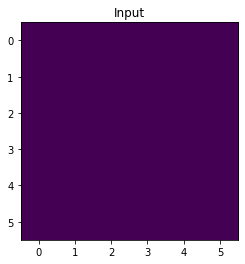

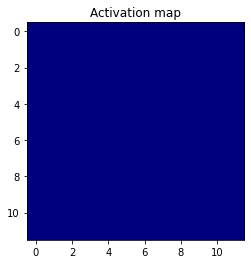

In [8]:
# Extract weights of the classification layer
W = model.layers[-1].get_weights()[0]

# Generate a test image
X, y = create_image()

# Predict the class
prediction = model.predict(X.reshape((1, 6, 6)))
predicted_class = np.argmax(prediction)

# Generate a feature map
feature_map = model_feature_map.predict(X.reshape((1, 6, 6)))

# Weights that correspond to the predicted class
W_class = W[:,predicted_class]

print(f'Input:\n{X}\n')
print(f'Predicted class:\n{predicted_class}\n')
print(f'Classification layer weights:\n{W}\n')
print(f'Classification layer weights for predicted class:\n{W_class}\n')
print(f'Feature map:\n{feature_map}\n')

# Create the activation map
activation_map = feature_map.dot(W_class)[0]

# Upscale the activation map
activation_map = sp.ndimage.zoom(activation_map, (6, 6))

plt.imshow(X)
plt.title('Input')
plt.show()

plt.imshow(activation_map, cmap='jet')
plt.title('Activation map')
plt.show()